### Copyright 2022 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Dijkstra's pathfinding algorithm

## Data structure for storing node info

In [1]:
class Node:
    node_id = 0
    def __init__(self, name_input):
        self.name = name_input
        self.predecessor = 'NIL'
        self.distance = float('inf')
        self.adjacencylist = []
        self.weightlist = []
        my_dict[self.name] = Node.node_id
        Node.node_id += 1
        self.t_discovered = 'NIL'
        self.t_visited = 'NIL'

## Global variables for storing information

In [2]:
WEIGHTED_GRAPH = True # All booleans can be changed below. Please do not change them here!
DIRECTED_GRAPH = True
GRAPHS_PER_LINE = 2
DISPLAY_STEP_BY_STEP = False
STOP_AT_TARGET = False
my_dict = {} # for easier access, each node's name returns said node's index in the list if hashed. 
             # nodes is the only list which stores objects. All the other lists only store names, which can then be hashed to access the actual object
nodes = []
visited_nodes = []
discovered_nodes = []
currently_visiting = [] # For highlighting the currently visited node and the one which is being inspected
current_distance = []
updated_nodes = []

current_step = 0
visited_nodes_steps, discovered_nodes_steps = [], []

In [3]:
import copy
def save_graph():
    global visited_nodes_steps, discovered_nodes_steps
    # A deep copy is needed as the data is not supposed to be changed.
    # Not using a deep copy would result in all previous states being overwritten by the final one
    visited_nodes_steps.append(copy.deepcopy(visited_nodes))
    discovered_nodes_steps.append(copy.deepcopy(discovered_nodes))

In [4]:
def reset_results(): # Resets data after results were printed
    global discovered_nodes, visited_nodes, currently_visiting, current_step, visited_nodes_steps, discovered_nodes_steps, current_distance, updated_nodes
    discovered_nodes, visited_nodes = [], []
    currently_visiting = []
    current_step = 0
    visited_nodes_steps, discovered_nodes_steps = [], []
    current_distance, updated_nodes = [], []
    # Set node statistics back to initial values.
    for node in nodes:  
        node.predecessor = 'NIL'
        node.distance = float('inf')
        node.t_discovered = 'NIL'
        node.t_visited = 'NIL'

In [5]:
def reset_graph():
    global nodes, my_dict
    # I want to seperate resetting results from resetting the entire graph. Resetting the graph requieres reseting results
    reset_results()
    nodes = []
    my_dict = {}
    Node.node_id = 0

## Output colors

In [6]:
# Node color in output. Defaults are 'white', 'slategray', 'lightgray'
COL_NODE_NOT_VISITED = 'white' # Not yet visited
COL_NODE_CURRENTLY_VISITING = 'slategray' # Will highlight the currently visited node if DISPLAY_STEP_BY_STEP = True
COL_NODE_VISITED = 'lightgray'
# Color for node font (black text on black background is not a good idea afterall). Defaults are 'black', 'black', 'black', 'white'
COL_FC_NODE_NOT_VISITED = 'black'
COL_FC_NODE_CURRENTLY_VISITING = 'black'
COL_FC_NODE_VISITED = 'black'
# Color for arrow and text when distance is updated
COL_UPDATED = 'red'

## Visualization

In [7]:
from graphviz import Digraph
from graphviz import Graph
def draw_graphs():
    global current_step # Step index
    while current_step < len(visited_nodes_steps):
        steps_taken = 0 # For label output "(Steps x - y)"
        if DIRECTED_GRAPH:
            dot = Digraph()
        else:
            dot = Graph(strict=True) # strict prevents multiple edges between two nodes, which are unnecessary in an undirected Graph
        for _ in range(GRAPHS_PER_LINE):
            if current_step >= len(visited_nodes_steps):
                break
            create_subgraph(dot)
            steps_taken += 1
        
        if current_step-steps_taken+1 == 1: # Only True for the first row of output. I want Dijkstra to only be printed on the first row of output
            displayed_algorithm_name = 'Dijkstra '
        else:
            displayed_algorithm_name = '' # Leaving out the algorithm name for subsequent images
        
        if steps_taken == 1:
            label_input = displayed_algorithm_name + 'Step ' + str(current_step)
        else:
            label_input = displayed_algorithm_name + 'Steps ' + str(current_step-steps_taken+1) + ' - ' + str(current_step)
        dot.attr(labelloc='t', label=label_input)
        display(dot)

In [8]:
def create_subgraph(dot):
    global current_step
    # sub represents each subgraph for a given dot (graph) object. They have to be named in the form 'cluster_x' with x being an integer
    with dot.subgraph(name='cluster_' + str(current_step)) as sub:
        # Adding the nodes
        for index, node in enumerate(nodes):
            if DISPLAY_STEP_BY_STEP and node.name == currently_visiting[current_step][0]:
                corresponding_bg_color = COL_NODE_CURRENTLY_VISITING
                corresponding_font_color = COL_FC_NODE_CURRENTLY_VISITING
            elif node.name not in visited_nodes_steps[current_step]:
                corresponding_bg_color = COL_NODE_NOT_VISITED
                corresponding_font_color = COL_FC_NODE_NOT_VISITED
            else:
                corresponding_bg_color = COL_NODE_VISITED
                corresponding_font_color = COL_FC_NODE_VISITED
            if node.name in updated_nodes[current_step]:
                corresponding_font_color = COL_UPDATED
            # The node currently insepcted is highlighted with having a different shape. All others are ellipses    
            if node.name == currently_visiting[current_step][1]:
            #if node.name in updated_nodes[current_step]:
                corresponding_node_shape = 'octagon'
            else:
                corresponding_node_shape = 'ellipse'
            
            sub.attr('node', style='filled', fillcolor=corresponding_bg_color, fontcolor=corresponding_font_color, shape=corresponding_node_shape)
            sub.node(str(current_step)+str(node.name), node.name + ': ' + str(current_distance[current_step][index]))
        # Adding the edges
        for node in nodes:
            for weight_index, adjacent_name in enumerate(node.adjacencylist):
                if node.name == currently_visiting[current_step][0] and adjacent_name in updated_nodes[current_step]:
                    corresponding_arrow_color = COL_UPDATED
                else:
                    # Used to prevent arrow colors being overwritten in an undirected graph (can be ignored for directed graphs)
                    if DIRECTED_GRAPH or node.name not in updated_nodes[current_step] or adjacent_name != currently_visiting[current_step][0]:
                        corresponding_arrow_color = 'black'
                    else:
                        corresponding_arrow_color = COL_UPDATED
                if WEIGHTED_GRAPH: # If it's an unweighted graph, the label can be left out entirely   
                    sub.attr('edge', label=str(node.weightlist[weight_index]), color=corresponding_arrow_color)
                else:
                    sub.attr('edge', color=corresponding_arrow_color)
                sub.edge(str(current_step)+str(node.name), str(current_step)+str(adjacent_name))
        current_step += 1
        sub.attr(labelloc='b', label='(' + str(current_step) + ')', color='transparent') # color='transparent' gets rid of those boxes around each subgraph

In [9]:
def show_legend():
    if DIRECTED_GRAPH:
        dot = Digraph()
    else:
        dot = Graph()
    # Nodes
    dot.attr('node', style='filled', fillcolor=COL_NODE_NOT_VISITED, fontcolor=COL_FC_NODE_NOT_VISITED)
    dot.node('not visited')
    dot.attr('node', style='filled', fillcolor=COL_NODE_VISITED, fontcolor=COL_FC_NODE_VISITED)
    dot.node('visited')
    
    if DISPLAY_STEP_BY_STEP:
        dot.attr('node', style='filled', fillcolor=COL_NODE_CURRENTLY_VISITING, fontcolor=COL_FC_NODE_CURRENTLY_VISITING)
        dot.node('currently visiting')
        dot.attr('node', style='filled', fillcolor=COL_NODE_NOT_VISITED, fontcolor=COL_FC_NODE_NOT_VISITED, shape='octagon')
        dot.node('inspected\n and not updated')
        dot.attr('node', style='filled', fillcolor=COL_NODE_NOT_VISITED, fontcolor=COL_UPDATED, shape='octagon')
        dot.node('inspected\n and updated')
    else:
        dot.attr('node', style='filled', fillcolor=COL_NODE_NOT_VISITED, fontcolor=COL_UPDATED)
        dot.node('distance\n updated')
    # Edges
    if DISPLAY_STEP_BY_STEP:
        dot.attr('edge', color='black')
        dot.edge('currently visiting', 'inspected\n and not updated')
        dot.attr('edge', color=COL_UPDATED)
        dot.edge('currently visiting', 'inspected\n and updated')
    # Title and output
    dot.attr(labelloc='t', label='Legend for nodes and edges')
    display(dot)

## Visualizing the chart with the results

In [10]:
X_FIGSIZE_SCALING_FACTOR = 1.5
X_MIN_FIGSIZE = 11
BOTTOM_TEXT_Y_CORD = 0.25 # y coordinate of the bottom text row
X_INFO_START = 1 # x coordinate where the first column of information starts (excluding column with labels such as name, predecessor, etc.)
Y_OFFSET_VLINE_HEIGHT = 0.15 # How many coordinate units the vertical lines are allowed to be higher/lower than the top/bottom text row
OFFSET = 0.5
COL_LINES = 'k'
REGULAR_LINE_WIDTH = 2
TOP_H_LINE_WIDTH = 4

In [11]:
import matplotlib.pyplot as plt
def show_result_chart(start_node, target):
    x_figsize =len(nodes)*X_FIGSIZE_SCALING_FACTOR # Scaling figure size with number of nodes
    if x_figsize < X_MIN_FIGSIZE:
        x_figsize = X_MIN_FIGSIZE
    plt.figure(figsize=(x_figsize, 6))
    if INCLUDE_TIME:
        # Rows of information means distance, predecessor, etc.
        amt_information_rows = 5
    else:
        amt_information_rows = 3
    amt_h_lines = amt_information_rows-1
    y_end = amt_information_rows*OFFSET # The coordinate where the y axis ends
    x_end = (len(nodes)+1)*OFFSET+OFFSET/2 # The coordinate where the x axis ends
    plt.axis([0, x_end, 0, y_end]) # x_start, x_end, y_start, y_end
    plt.axis('off')
    # Plotting the regular hlines
    for j in range(0, amt_h_lines-1):
        plt.hlines(xmin=0, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + j*OFFSET, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    # Plotting the hline at the top 
    plt.hlines(xmin=-5, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + (amt_h_lines-1)*OFFSET, color=COL_LINES, linewidth=TOP_H_LINE_WIDTH)
    info_y_cords = []
    information_labels = ['Name', 'Distance', 'Predecessor', 'Step where\n discovered', 'Step where\n visited']
    for j in range(0, amt_information_rows):
        info_y_cords.append(BOTTOM_TEXT_Y_CORD + j*OFFSET)
        plt.text(x=0, y=BOTTOM_TEXT_Y_CORD + j*OFFSET, s=information_labels[amt_information_rows-j-1], fontsize=16, verticalalignment='center', horizontalalignment='left')
    for node_index, node in enumerate(nodes):
        if not isinstance(node.distance, str): # Only False when distance is infinity. I want to increase infinity symbol size without increasing the numbers' font-size
            distance_fontsize = 16
        else:
            distance_fontsize = 25
        x_cord = X_INFO_START + node_index*OFFSET
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s=str(node.name), fontsize=16, verticalalignment='center', horizontalalignment='center')
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(node.distance), fontsize=distance_fontsize, verticalalignment='center', horizontalalignment='center')
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(node.predecessor), fontsize=16, verticalalignment='center', horizontalalignment='center')
        if INCLUDE_TIME:
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-4)*OFFSET, s=str(node.t_discovered), fontsize=16, verticalalignment='center', horizontalalignment='center')
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-5)*OFFSET, s=str(node.t_visited), fontsize=16, verticalalignment='center', horizontalalignment='center')
    for vline_index, _ in enumerate(nodes):
        plt.vlines(x=X_INFO_START-OFFSET/2 + vline_index*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    start_text =  '(Starting node: ' + start_node
    if STOP_AT_TARGET:
        start_text += ', stop at ' + target
    start_text += ')'
    plt.title('Dijkstra result ' + start_text, fontsize=20)
    plt.show()

## Functions for adding nodes and edges

In [12]:
def create_graph(nodearray, edgearray):
    add_nodes(nodearray)
    add_edges(edgearray)

def add_nodes(nodearray):
    global nodes
    for node_name in nodearray:
        if my_dict.get(node_name) is None: # If node was not added already
            nodes.append(Node(node_name))

def add_edges(edgearray):
    weighted_edgearray = []
    for my_tuple in edgearray:
        if len(my_tuple) == 2 or not WEIGHTED_GRAPH: # len(my_tuple) is 2 when only start and destination are in it, meaning weight was left out. In that case add a weight of 1
            weighted_edgearray.append((my_tuple[0], my_tuple[1], 1))
        else: # Weights already present in input
            weighted_edgearray.append((my_tuple[0], my_tuple[1], my_tuple[2]))

    for start, dest, weight in weighted_edgearray:
        start_index = my_dict.get(start) # Access to index of node element instead of name
        dest_index = my_dict.get(dest)
        # If my_dict.get(x) returns None that means that x was not found in the hashmap, implying the node was not inserted and does not exist or else it would be in the hashmap
        if start_index is not None and dest_index is not None:
            # If this edge was not added before (multiple edges facing the same direction between two nodes is forbidden here)
            if dest not in nodes[start_index].adjacencylist:
                # Each node is given a unique id at the time of insertion. By sorting the adjacencylist according to this unique id,
                # you can define which node is chosen when there are multiple options available.
                # Having nodearray = ['A', 'B', 'C' ...] gurantees that if given a "choice", the algorithm will always visit 'A' over 'B', 'B' over 'C' and 'A' over 'C'
                at_index = len(nodes[start_index].adjacencylist)
                for index, adjacent in enumerate(nodes[start_index].adjacencylist):
                    if my_dict[adjacent] > my_dict[dest]:
                        at_index = index
                        break
                nodes[start_index].adjacencylist.insert(at_index, dest)
                nodes[start_index].weightlist.insert(at_index, weight)
            # If it is an undirected graph, also add the reversed direction with the same weight but only if the edge was not added already
            if not DIRECTED_GRAPH and start not in nodes[dest_index].adjacencylist:
                at_index = len(nodes[dest_index].adjacencylist)
                for index, adjacent in enumerate(nodes[dest_index].adjacencylist):
                    if my_dict[adjacent] > my_dict[start]:
                        at_index = index
                        break
                nodes[dest_index].adjacencylist.insert(at_index, start)
                nodes[dest_index].weightlist.insert(at_index, weight)

## Generation of a random graph

In [13]:
import random
def generate_random_graph(amount_of_nodes, min_max_distances):
    # Check user input
    if min_max_distances[0] > min_max_distances[1]:
        print("\nERROR: No valid range for minimum and maximum distances")
        return
    # Nodes ('A' = 65 in ASCII)
    nodearray = []
    for j in range(0, amount_of_nodes):
        nodearray.append(chr(65+j)) # Cast into ASCII character starting at 'A'
    add_nodes(nodearray)
    # Edges
    edgearray = []
    all_options = list(range(65, 65+amount_of_nodes)) # All nodes (their ASCII values)
    for node in nodearray:
        if BIAS_TOWARDS_CONNECTED_GRAPHS:
            amt_edges = random.randint(1, amount_of_nodes-1) # -1 since node cannot have a loop to itself
        else:
            amt_edges = random.randint(0, amount_of_nodes-1) # Node is allowed to have no edges in that case
        # Randomly select a destination (where the edge is going to)
        unavailable_options = [ord(node)] # Already used options initialized with the node itself, since loops are forbidden
        for j in range(amt_edges):
            # Have the programm randomly choose available options (all options - unavaiable options)
            destination = random.choice(list(set(all_options) - set(unavailable_options)))
            unavailable_options.append(destination)
            destination = chr(destination)
            distance = random.randint(min_max_distances[0], min_max_distances[1])
            edgearray.append((node, destination, distance))
    if BIAS_TOWARDS_CONNECTED_GRAPHS:
        has_a_way_to_it = [False] * amount_of_nodes # Create an array of Booleans to check which nodes have no edge going towards them
        for edge in edgearray:
            has_a_way_to_it[ord(edge[1])-65] = True # edge[1] is the destination part of the used tuple syntax.
        for index, bool_has_a_way_to_it in enumerate(has_a_way_to_it):
            if not bool_has_a_way_to_it: # If a node has no edge going towards it, then just create one originating from a random start node
                start = random.choice(list(set(all_options) - set([ord(nodearray[index])])))
                start = chr(start)
                distance = random.randint(min_max_distances[0], min_max_distances[1])
                edgearray.append((start, nodearray[index], distance))
    add_edges(edgearray)
    random_start = nodearray[random.randint(0, len(nodearray)-1)]
    # I will make this more comprehensible if it is ever needed
    random_target = chr(random.choice(list(set(all_options) - set([ord(random_start)]))))       
    return random_start, random_target

## Implementation of a min priority queue

In [14]:
class PQ_Node():
    def __init__(self, name_input, prio_input):
        self.name = name_input
        self.prio = prio_input

In [15]:
class PriorityQueue():
    def __init__(self):
        self.elements = []
        self.heapsize = 0
        for node in nodes:
            self.elements.append(PQ_Node(node.name, float('inf'))) # Positive infinity
            # No need for heap_decrease_key as priority is infinity for all elements
            self.heapsize += 1   

    def is_empty(self):
        return self.heapsize == 0
            
    def parent(self, i):
        return (i-1)//2

    def left(self, i):
        return 2*i+1

    def right(self, i):
        return 2*i+2

    def heap_decrease_key(self, i, prio_input):
        self.elements[i].prio = prio_input   
        while i > 0 and self.elements[self.parent(i)].prio > self.elements[i].prio:
            self.elements[i], self.elements[self.parent(i)] = self.elements[self.parent(i)], self.elements[i]
            i = self.parent(i)

    def extract_min(self):   
        min_element = copy.deepcopy(self.elements[0]) 
        self.heapsize -= 1
        self.elements[0], self.elements[self.heapsize] = self.elements[self.heapsize], self.elements[0] # Swaps first element and last element to delete the previous first and bubble down the previous last
        self.elements = self.elements[:self.heapsize] # Deletes last element
        self.min_heapify(0)
        return min_element

    def min_heapify(self, i):
        l = self.left(i)
        r = self.right(i)   
        if l < self.heapsize and self.elements[l].prio < self.elements[i].prio:
            minimum = l
        else:
            minimum = i       
        if r < self.heapsize and self.elements[r].prio < self.elements[minimum].prio:
            minimum = r   
        if minimum != i:
            self.elements[i], self.elements[minimum] = self.elements[minimum], self.elements[i]
            self.min_heapify(minimum)

    def reduce_priority(self, name_to_be_searched, prio_input):   
        for index, element in enumerate(self.elements):
            if element.name == name_to_be_searched:
                at_index = index
                break
        self.heap_decrease_key(at_index, prio_input)

## Functions to save all the states of the graph

In [16]:
# currently_visited is for highlighting the node currently being visited
# currently_inspected is the same for the node being insepcted (gets a different shape in that case)
def save_state(currently_visited, currently_inspected):
    global currently_visiting, current_distance, updated_nodes
    save_graph()
    currently_visiting.append((currently_visited, currently_inspected))
# Notes where a change in distance happens. Used for highlighting the change in red font
    distance_array = []
    for node in nodes:
        distance_array.append(node.distance)
    changed_node_names = []
    if len(current_distance) > 0:
        for j in range(0, len(nodes)):
            if distance_array[j] != current_distance[-1][j]:
                changed_node_names.append(nodes[j].name)
    current_distance.append(distance_array)
    updated_nodes.append(changed_node_names)

## Dijkstra implementation

In [17]:
def dijkstra(start_node_name, target='_'):
    global visited_nodes, discovered_nodes, currently_visiting
    start_index = my_dict.get(start_node_name)
    if start_index is None:
        print("\nERROR: The Starting Node", start_node_name, "does not exist. Please make sure you have given the correct name to the start variable")
        return
    time = 1 # 1 instead of 0, since steps start at 1
    nodes[start_index].distance = 0
    Q = PriorityQueue()
    Q.reduce_priority(start_node_name, 0) # Set starting node distance to 0
    discovered_nodes.append(start_node_name)
    nodes[start_index].t_discovered = time
    if not DISPLAY_STEP_BY_STEP: # The images are delayed by one image if DISPLAY_STEP_BY_STEP == False
        prev_u_name = start_node_name
    while not Q.is_empty():
        u = Q.extract_min()
        time += 1
        if DISPLAY_STEP_BY_STEP:
            save_state('_', '_')
        else:
            save_state(prev_u_name, '_')
            prev_u_name = u.name
        visited_nodes.append(u.name)
        if STOP_AT_TARGET and u.name == target:
            break
        for index, adjacent in enumerate(nodes[my_dict[u.name]].adjacencylist):
            if adjacent not in visited_nodes:
                if adjacent not in discovered_nodes:
                    discovered_nodes.append(adjacent)
                    nodes[my_dict[adjacent]].t_discovered = time
                Q = relax(u.name, adjacent, index, Q)
                if DISPLAY_STEP_BY_STEP:
                    time += 1
                    save_state(u.name, adjacent)
        nodes[my_dict[u.name]].t_visited = time
    save_state('_', '_')
    show_legend()
    draw_graphs()
    show_result_chart(start_node_name, target)

def relax(u_name, adjacent_name, adjacent_index_in_adjacencylist, Q):
    u_node = nodes[my_dict[u_name]]
    adjacent_node = nodes[my_dict[adjacent_name]]
    from_u_to_adjacent = u_node.weightlist[adjacent_index_in_adjacencylist]
    if adjacent_node.distance > u_node.distance + from_u_to_adjacent:
        adjacent_node.distance = u_node.distance + from_u_to_adjacent
        adjacent_node.predecessor = u_name
        Q.reduce_priority(adjacent_name, adjacent_node.distance)
    return Q
    
def show_shortest_path(start_name, destination_name):
    if my_dict.get(destination_name) is None:
        print("\nERROR: The target node does not exist (show_shortest_path)")
        return
    if destination_name == start_name:
        print("\nThe path from a node to itself is trivial")
        return
    destination_node = nodes[my_dict[destination_name]]
    if destination_node.predecessor == 'NIL' and destination_node.distance != 0:
        print("\nThere is no connection between the starting node", start_name, "and the target", destination_name)
        return
    path = [destination_node.name]
    curr_node = destination_node
    while curr_node.predecessor != 'NIL' and curr_node.name != start_name:
        path.append(curr_node.predecessor)
        curr_node = nodes[my_dict[curr_node.predecessor]]
    path.reverse()
    
    ARROW_OFFSET = 0.2 # Distance between coordinate [xn, 0.5] and start of arrow going towards [xn+1, 0.5]. The same for the opposite direction
    plt.figure(figsize=(len(path), 1))
    plt.axis([0, len(path)-1, 0, 1]) # x_start, x_end, y_start, y_end
    plt.axis('off')
    for j in range(0, len(path)):
        plt.text(x=j, y=0.5, s=path[j], fontsize=16, verticalalignment='center', horizontalalignment='center')
    for j in range(0, len(path)-1):
        plt.arrow(x=j+ARROW_OFFSET, y=0.5, dx=1-2*ARROW_OFFSET, dy=0, length_includes_head=True, head_width=0.1, width=0.0025)
    plt.title('Path from ' + str(start_name) + ' to ' + str(destination_name) + ' (' + str(destination_node.distance) + ')', fontsize=20)
    plt.show()

## Graph type and graphical output options for the example graph

In [18]:
WEIGHTED_GRAPH = True # Setting it to False automatically sets all weights to 1
DIRECTED_GRAPH = True # Setting it to False automatically makes all edges bidirectional. So for every edge A --> B, 
                # there will also be an edge B --> A with the same weight (in case of conflict, the first to be input is selected)
DISPLAY_STEP_BY_STEP = True # True: Draws a new image every time a node is disovered or updated
                            # False: Draws a new image when the entire adjacencylist of a given object has been inspected
INCLUDE_TIME = True # If True, will includes step of discovery and visit for each node in result chart
STOP_AT_TARGET = False # If True, algorithm will stop upon reaching the target
GRAPHS_PER_LINE = 4 # Adjust how many graphs you want displayed in a single row

## Example

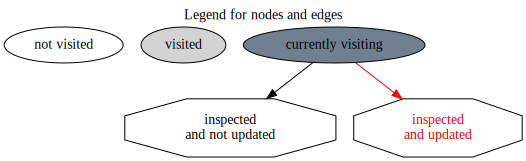

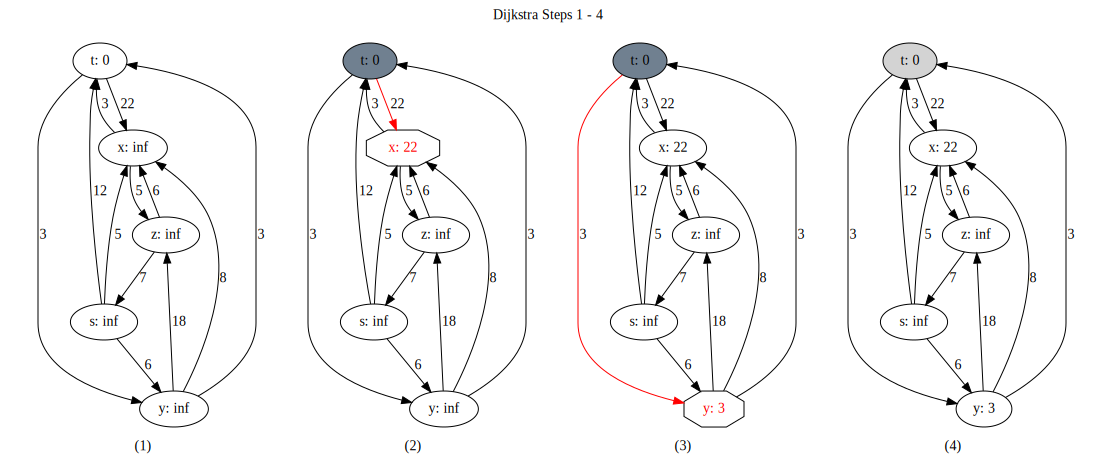

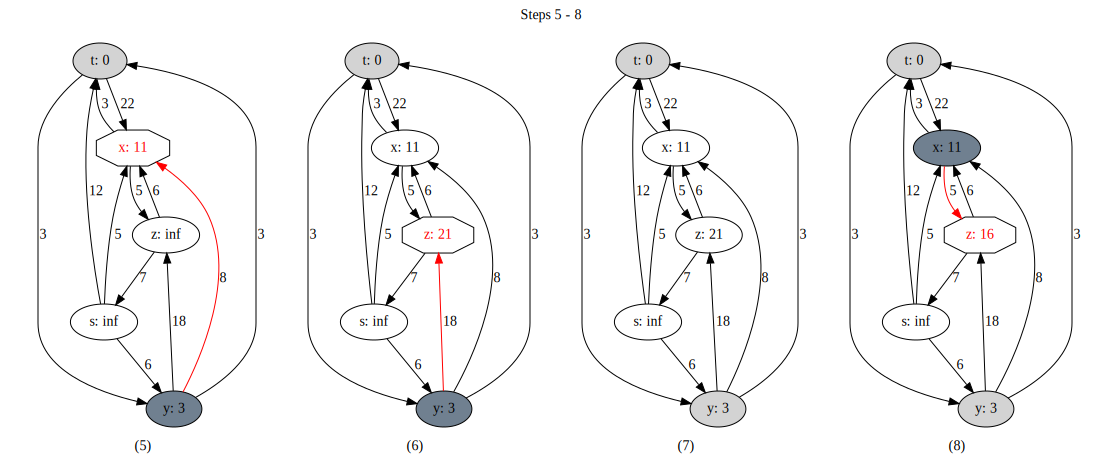

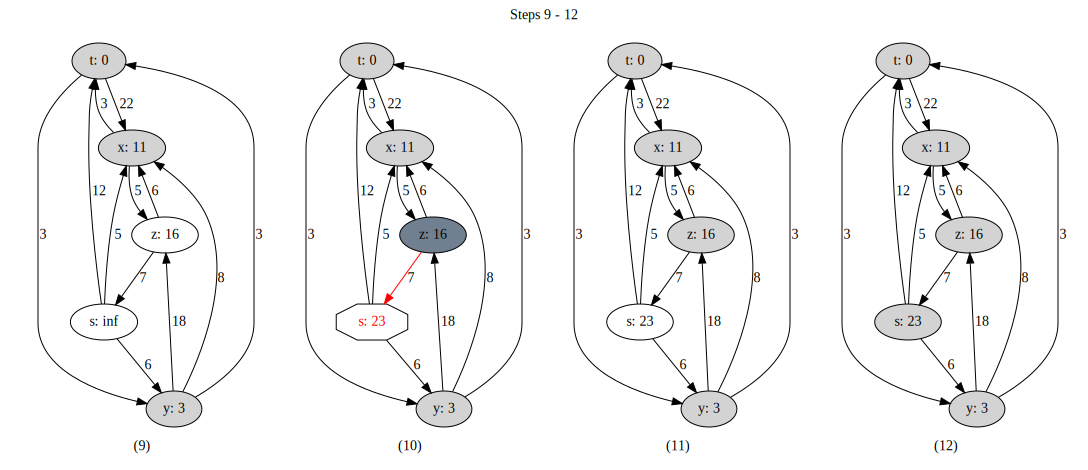

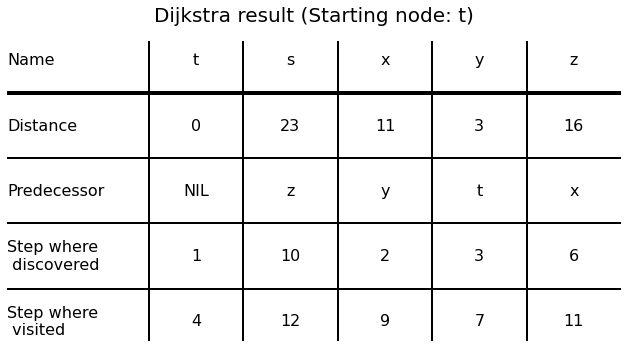

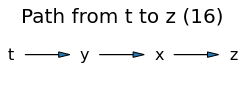

In [19]:
# Input the names of the nodes here

nodearray = ['t', 's', 'x', 'y', 'z']

# It is a list (array) of 3-tuples. left and middle components are strings refering to the node names. 
# Left is the start of an edge and the middle is the destination. The rightmost value is the weight of said edge.
# Syntax: edgearray = [('START', 'DESTINATION', WEIGHT), ('STARTx', 'DESTINATIONy', WEIGHTz), ...]
# If you want an unweighted graph, replace the above boolean True with a False.
# In that case you can use any random weights and they will be turned to 1 automatically,
# meaning edgearray = [('A', 'B', 12), ('B', 'C', 151)] will be turned to [('A', 'B', 1), ('B', 'C', 1)]
# Alternatively you can just leave out the weight altogether. Doing this will result in weight 1 regardless of whether its a weighted graph or not
# edgearray = [('A', 'B'), ('B', 'C')] is the same as [('A', 'B', 1), ('B', 'C', 1)]

edgearray = [('t', 'y', 3), ('t', 'x', 22), ('y', 't', 3), ('y', 'z', 18), ('y', 'x', 8), ('z', 'x', 6), 
             ('z', 's', 7), ('s', 'y', 6), ('s', 't', 12), ('s', 'x', 5), ('x', 'z', 5), ('x', 't', 3)]

create_graph(nodearray, edgearray)

# Input the name of the starting node here
start = 't'

# Input the name of the target node here. If you have set STOP_AT_TARGET above to True, then reaching this node will end the algorithm
# Einther way, a path from the starting node to the target node will be displayed at the bottom
target = 'z'

dijkstra(start, target)
show_shortest_path(start, target)
reset_graph()

## Select graph type and graphical output options for randomly generated graph here

In [20]:
# See above for explanations
WEIGHTED_GRAPH = True
DIRECTED_GRAPH = True
DISPLAY_STEP_BY_STEP = False
INCLUDE_TIME = True
STOP_AT_TARGET = False
GRAPHS_PER_LINE = 4 # Recommended: 4 for roughly 5 nodes or less, 2 for roughly 10 nodes

## Select random graph properties

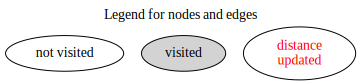

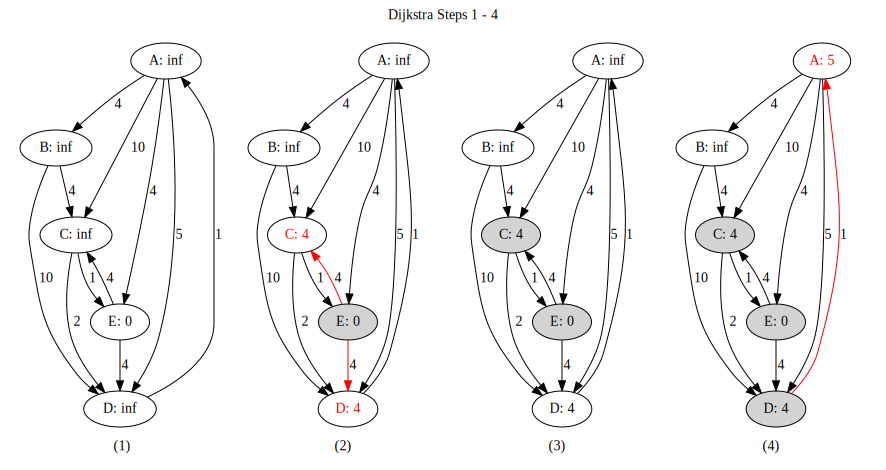

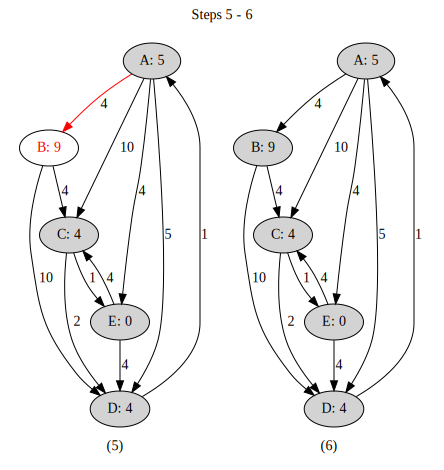

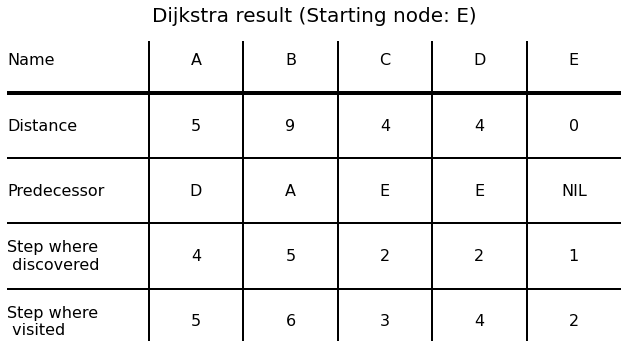

In [21]:
# If set to True, it will gurantee that every node has atleast one outgoing and one incoming edge
BIAS_TOWARDS_CONNECTED_GRAPHS = True
# Change the amount of nodes the randomly generated graph is supposed to have here
amount_of_nodes = 5
# Change the range possible weights between two nodes. In this example all edges have weights between 1 and 10
min_max_distances = [1, 10]

random_start, _ = generate_random_graph(amount_of_nodes, min_max_distances)
dijkstra(random_start)
reset_graph()

## Select graph type and graphical output options here

In [22]:
# See above for explanations
WEIGHTED_GRAPH = True
DIRECTED_GRAPH = True
DISPLAY_STEP_BY_STEP = True
INCLUDE_TIME = True
STOP_AT_TARGET = False
GRAPHS_PER_LINE = 4

## Your tests go here...

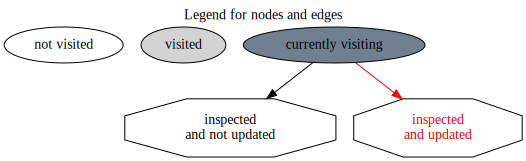

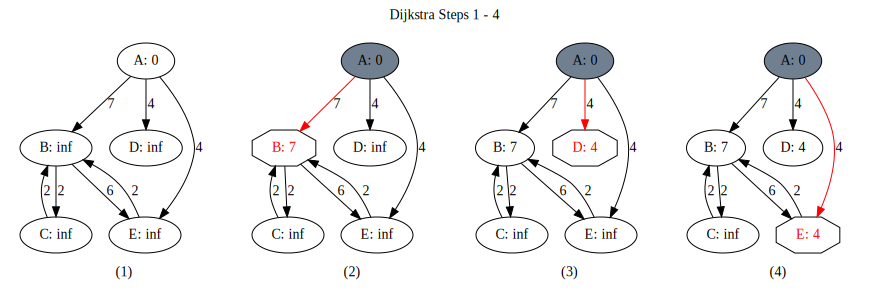

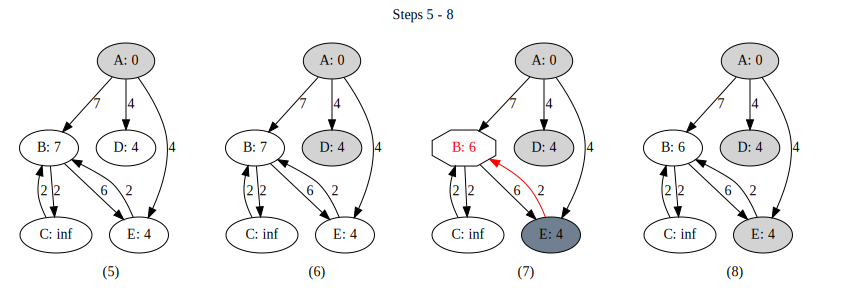

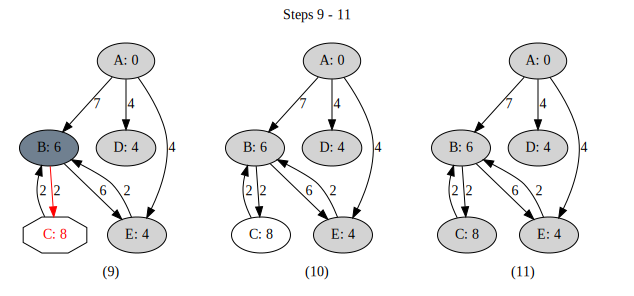

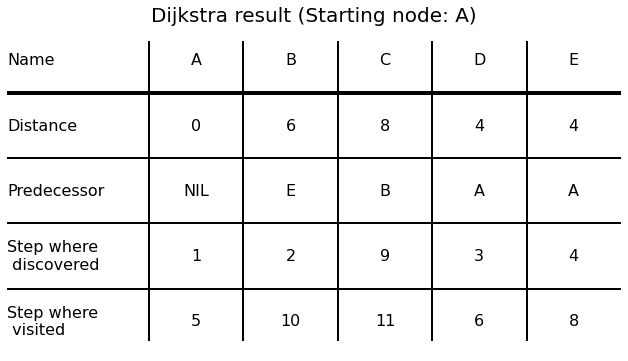

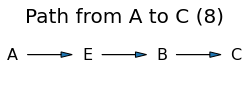

In [23]:
nodearray = ['A', 'B', 'C', 'D', 'E']

edgearray = [('A', 'B', 7), ('A', 'D', 4), ('A', 'E', 4), ('B', 'E', 6), ('E', 'B', 2), ('B', 'C', 2), ('C', 'B', 2)]

create_graph(nodearray, edgearray)

start = 'A'

target = 'C'

dijkstra(start, target)
show_shortest_path(start, target)
reset_graph()